#### Chapter 9
### Analyzing Neural Time Series Data
Python code for Chapter 9 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

### Import necessary libraries

Note: The following code requires the MNE library for topographical plotting.
If MNE is not installed, you can install it using pip:

`%pip install mne`


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import griddata
from scipy.signal import filtfilt, firls
from mne import create_info, EvokedArray, find_layout
from mne.channels import make_dig_montage

### Figure 9.1a

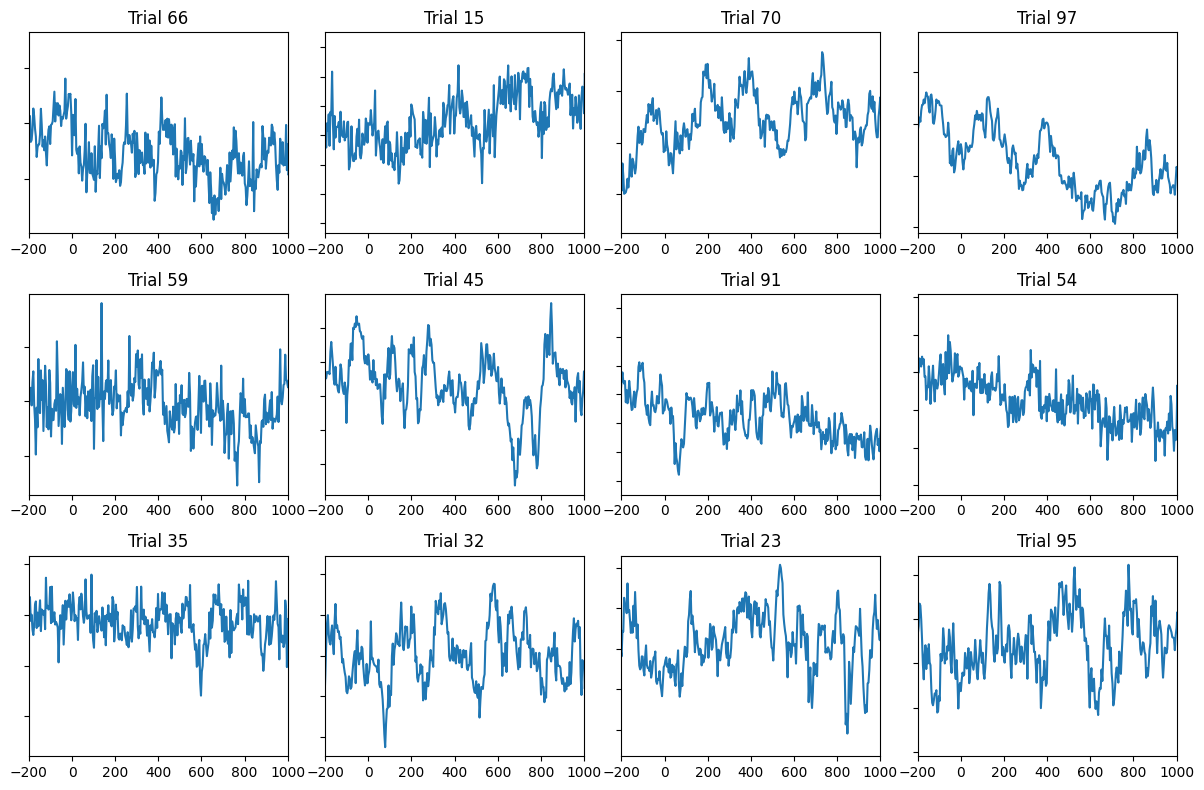

In [ ]:
# Load EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Plot a few trials from one channel
which_channel_to_plot = 'FCz'
channel_index = EEG['chanlocs'][0]['labels']==which_channel_to_plot
x_axis_limit = [-200, 1000]  # in ms
num_trials2plot = 12

fig, axs = plt.subplots(int(np.ceil(num_trials2plot / np.ceil(np.sqrt(num_trials2plot)))), 
                        int(np.ceil(np.sqrt(num_trials2plot))), figsize=(12, 8))
axs = axs.flatten()

for i in range(num_trials2plot):
    random_trial = np.random.choice(EEG['trials'][0][0], 1)
    axs[i].plot(EEG['times'][0], EEG['data'][channel_index, :, random_trial].flatten())
    axs[i].set_xlim(x_axis_limit)
    axs[i].set_title(f'Trial {random_trial[0]+1}')
    axs[i].set_yticklabels([])
plt.tight_layout()
plt.show()

### Figure 9.1b

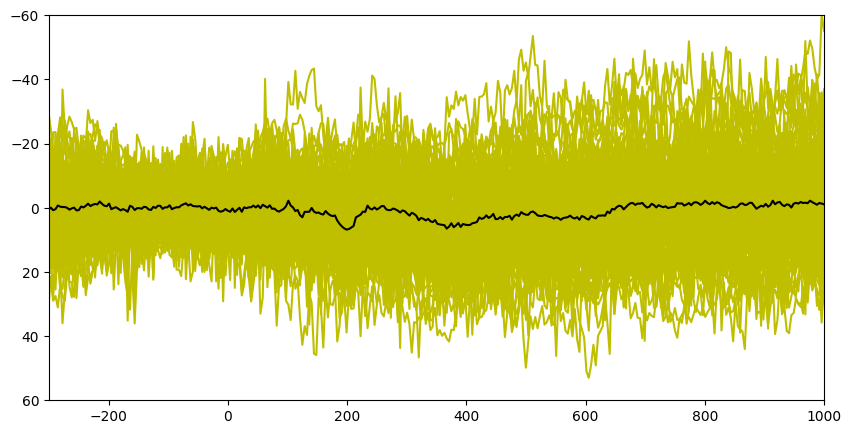

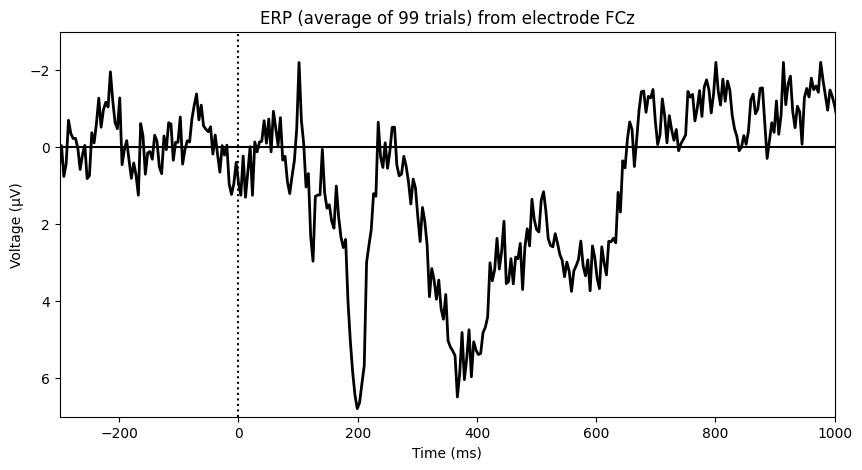

In [ ]:
plt.figure(figsize=(10, 5))
# Plot all trials
plt.plot(EEG['times'][0], np.squeeze(EEG['data'][channel_index, :, :]), 'y')
# plot ERP (simply the average time-domain signal)
plt.plot(EEG['times'][0], np.squeeze(np.mean(EEG['data'][channel_index, :, :], axis=2)), 'k')
plt.xlim([-300, 1000])
plt.ylim([-60, 60])
plt.gca().invert_yaxis()
plt.show()

# Plot ERP (Event-Related Potential)

plt.figure(figsize=(10, 5))
plt.plot(EEG['times'][0], np.squeeze(np.mean(EEG['data'][channel_index, :, :], axis=2)), 'k', linewidth=2)
plt.axhline(0, color='k')
plt.axvline(0, color='k', linestyle=':')
plt.xlim([-300, 1000])
plt.ylim([-3, 7])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'ERP (average of 99 trials) from electrode {EEG["chanlocs"][0][channel_index][0][0][0]}')
plt.gca().invert_yaxis()
plt.show()

### Figure 9.2

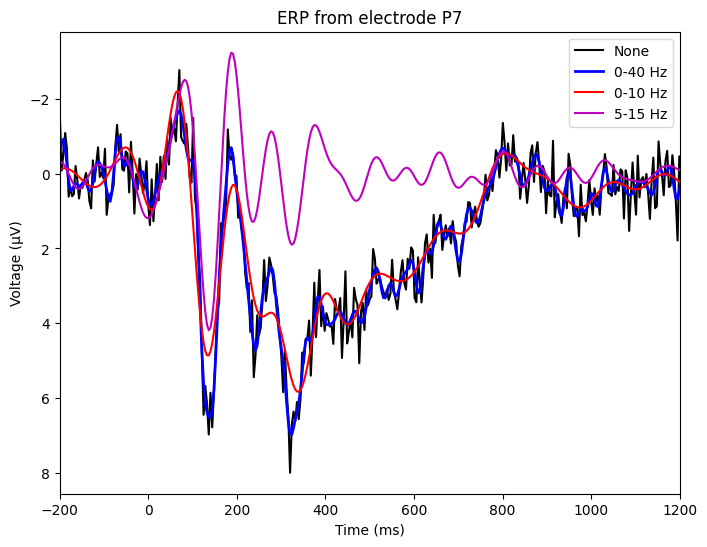

In [ ]:
# Plot filtered ERPs
chan2plot = 'P7'

erp = np.squeeze(np.mean(EEG['data'][EEG['chanlocs'][0]['labels']==chan2plot, :, :], axis=2))

# Define filter parameters
nyquist = EEG['srate'][0][0] / 2
transition_width = 0.15 # percent

# Filter from 0-40 Hz
filter_cutoff = 40
ffrequencies = [0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist] / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to40 = filtfilt(filterweights, 1, erp)

# Filter from 0-10 Hz
filter_cutoff = 10
ffrequencies = [0, filter_cutoff, filter_cutoff * (1 + transition_width), nyquist] / nyquist
idealresponse = [1, 1, 0, 0]
filterweights = firls(101, ffrequencies, idealresponse)
erp_0to10 = filtfilt(filterweights, 1, erp)

# Filter from 5-15 Hz
filter_low = 5
filter_high = 15
ffrequencies = [0, filter_low * (1 - transition_width), filter_low, filter_high, filter_high * (1 + transition_width), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(round(3 * (EEG['srate'][0][0] / filter_low)) + 1, ffrequencies, idealresponse)
erp_5to15 = filtfilt(filterweights, 1, erp)

# Plot all filtered ERPs
plt.figure(figsize=(8, 6))
plt.plot(EEG['times'][0], erp, 'k', label='None')
plt.plot(EEG['times'][0], erp_0to40, 'b', linewidth=2, label='0-40 Hz')
plt.plot(EEG['times'][0], erp_0to10, 'r', label='0-10 Hz')
plt.plot(EEG['times'][0], erp_5to15, 'm', label='5-15 Hz')
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'ERP from electrode {chan2plot}')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Figure 9.3

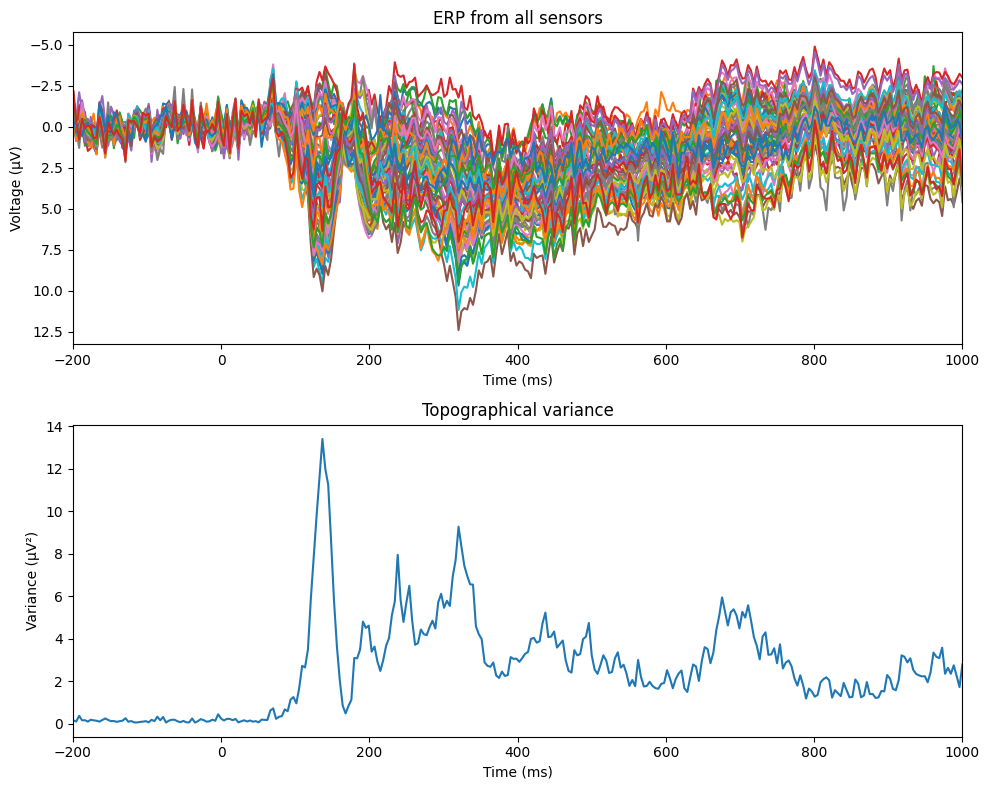

In [ ]:
plt.figure(figsize=(10, 8))

# Butterfly plot
plt.subplot(2, 1, 1)
plt.plot(EEG['times'][0], np.squeeze(np.mean(EEG['data'], axis=2)).T)
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title('ERP from all sensors')
plt.gca().invert_yaxis()

# Topographical variance plot
plt.subplot(2, 1, 2)
plt.plot(EEG['times'][0], np.var(np.mean(EEG['data'], axis=2), axis=0))
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Variance (μV²)')
plt.title('Topographical variance')
plt.tight_layout()
plt.show()

### Figure 9.4

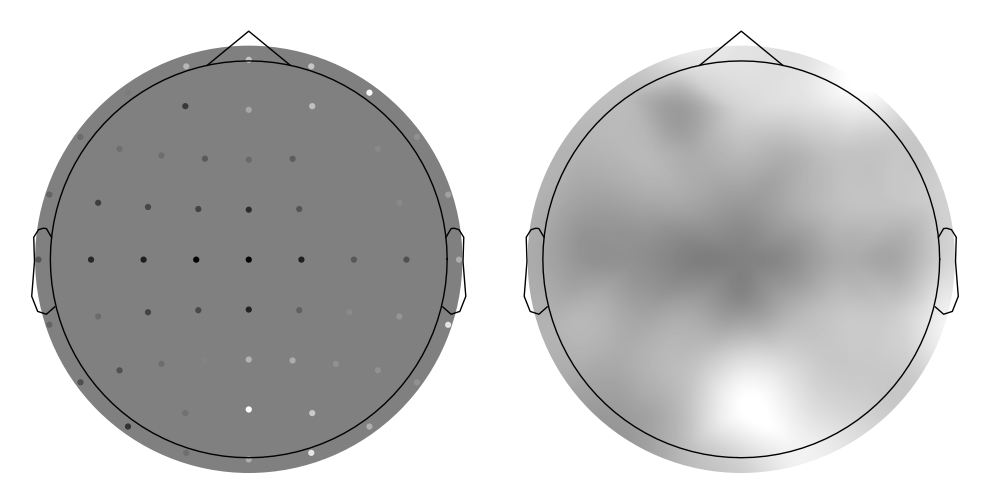

In [ ]:
c = -np.mean(EEG['data'][:, 299, :], axis=1)
c = c - np.min(c)
c = c / np.max(c)
c = np.tile(c, (3, 1))

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# note that we flip the y-coordinate here to match the Matlab figure
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
c = np.delete(c, exclude_chans, axis=1)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')
evoked1 = EvokedArray(np.zeros((len(chan_labels), 1)), info, tmin=EEG['xmin'][0][0])
evoked1.set_montage(montage)
evoked2 = EvokedArray(c[0, :, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked2.set_montage(montage)

# Plot using MNE's topomap function
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
evoked2.plot_topomap(sensors=False, contours=0, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='gray', axes=ax[1], show=False, times=-1, time_format='', colorbar=False)
evoked1.plot_topomap(sensors=False, contours=0, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='gray', vlim=ax[1].get_images()[0].get_clim(), axes=ax[0], show=False, times=-1, time_format='', colorbar=False)


pos_x = (find_layout(evoked1.info).pos[:, 0] - np.mean(find_layout(evoked1.info).pos[:, 0])) * 2.3 * EEG['chanlocs'][0][0]['sph_radius'][0][0]
pos_y = (find_layout(evoked1.info).pos[:, 1] - np.mean(find_layout(evoked1.info).pos[:, 0])) * 2.3 * EEG['chanlocs'][0][0]['sph_radius'][0][0]

# Plot the sensors using scatter
for i in range(len(pos_x)):
    ax[0].scatter(pos_x[i], pos_y[i], s=20, c=[c[0, i]], marker='o', cmap='gray', vmin=0, vmax=1, edgecolors='none')

plt.tight_layout()
plt.show()

### Introduction to topographical plotting

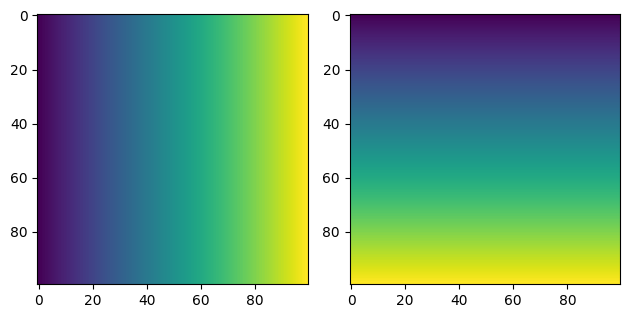

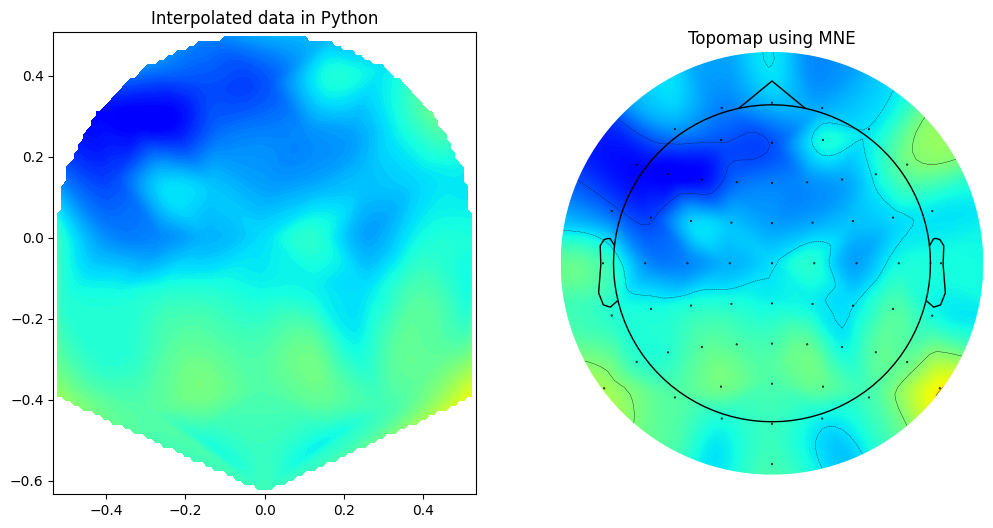

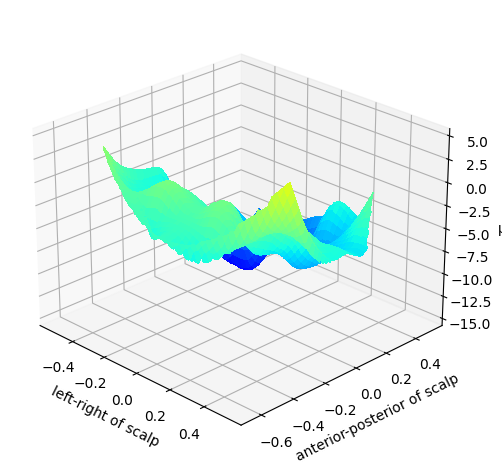

In [ ]:
def pol2cart(theta, radius):
    """Convert polar coordinates to Cartesian."""
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

timepoint2plot = 100  # in ms
trial2plot = np.random.choice(EEG['trials'][0][0], 1)[0]
color_limit = 20  # more-or-less arbitrary, but this is a good value

# Convert time point from ms to index
timepointidx = np.argmin(np.abs(EEG['times'][0] - timepoint2plot))

# Get X and Y coordinates of electrodes
th = np.pi / 180 * np.array([chan['theta'] for chan in EEG['chanlocs'][0]])
radii = np.array([chan['radius'] for chan in EEG['chanlocs'][0]])
electrode_locs_X, electrode_locs_Y = pol2cart(th, radii)

# Flatten the electrode location arrays
electrode_locs_X = electrode_locs_X.flatten()
electrode_locs_Y = electrode_locs_Y.flatten()

# Interpolate to get a nice surface
interpolation_level = 100
interpX = np.linspace(min(electrode_locs_X), max(electrode_locs_X), interpolation_level)
interpY = np.linspace(min(electrode_locs_Y), max(electrode_locs_Y), interpolation_level)

# meshgrid is a function that creates 2D grid locations based on 1D inputs
gridX, gridY = np.meshgrid(interpX, interpY)

# Let's look at these matrices
plt.figure()
plt.subplot(121)
plt.imshow(gridX, cmap='viridis')

plt.subplot(122)
plt.imshow(gridY)
plt.tight_layout()
plt.show()

# Interpolate the data on a 2D grid
interpolated_EEG_data = griddata((electrode_locs_X, electrode_locs_Y), EEG['data'][:, timepointidx, trial2plot], (gridX, gridY), method='cubic')

# Plot the interpolated data
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].contourf(interpY, interpX, interpolated_EEG_data.T, 100, cmap='jet', vmin=-color_limit, vmax=color_limit)
axs[0].set_title('Interpolated data in Python')

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(chan_labels, EEG['srate'], ch_types='eeg')
evoked = EvokedArray(EEG['data'][:, timepointidx, trial2plot, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)

# Plot using MNE's topomap function
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-color_limit*1000000, color_limit*1000000), axes=axs[1], show=False, times=-1, time_format='', colorbar=False)
axs[1].set_title('Topomap using MNE')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(gridX, gridY, interpolated_EEG_data.T, cmap='jet', linewidth=0, antialiased=False)
surf.set_clim(-color_limit, color_limit)
ax.set_xlabel('left-right of scalp')
ax.set_ylabel('anterior-posterior of scalp')
ax.set_zlabel('μV')
ax.view_init(elev=25, azim=-45)
ax.set_xlim([np.min(interpY) * 1.1, np.max(interpY) * 1.1])
ax.set_ylim([np.min(interpX) * 1.1, np.max(interpX) * 1.1])

plt.tight_layout()
plt.show()

### Figure 9.5

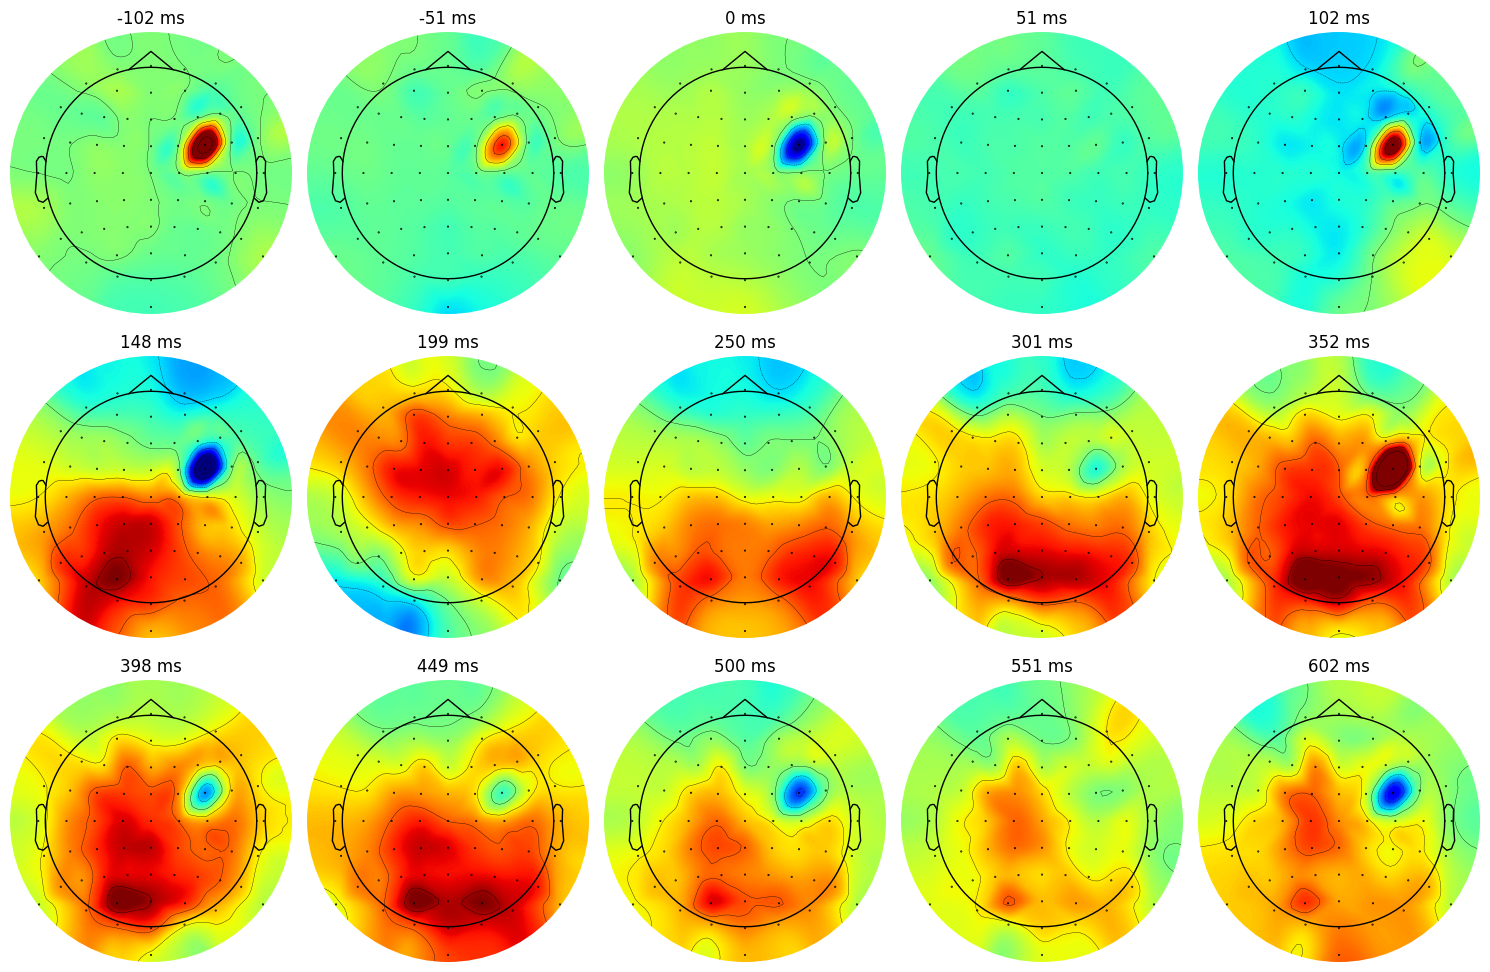

In [ ]:
times2plot = [np.argmin(np.abs(EEG['times'][0] - t)) for t in np.arange(-100, 650, 50)]

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(chan_labels, EEG['srate'], ch_types='eeg')
evoked = EvokedArray(np.mean(EEG['data'], axis=2) , info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)

# Plot the topomaps
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i, time_point in enumerate(times2plot):
    ax = axs[i // 5, i % 5]  # Determine the subplot position
    # Introduce a random noise to the FC4 channel at the specific time point
    evoked.data[EEG['chanlocs'][0]['labels']=='FC4', time_point] = np.random.randn() * 10
    # Plot the topomap
    evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-8000000, 8000000), axes=ax, show=False, times=evoked.times[time_point], colorbar=False)
    ax.set_title(f'{round(evoked.times[time_point]*1000)} ms')  # Convert seconds back to milliseconds for the title
plt.tight_layout()
plt.show()

### Figure 9.6

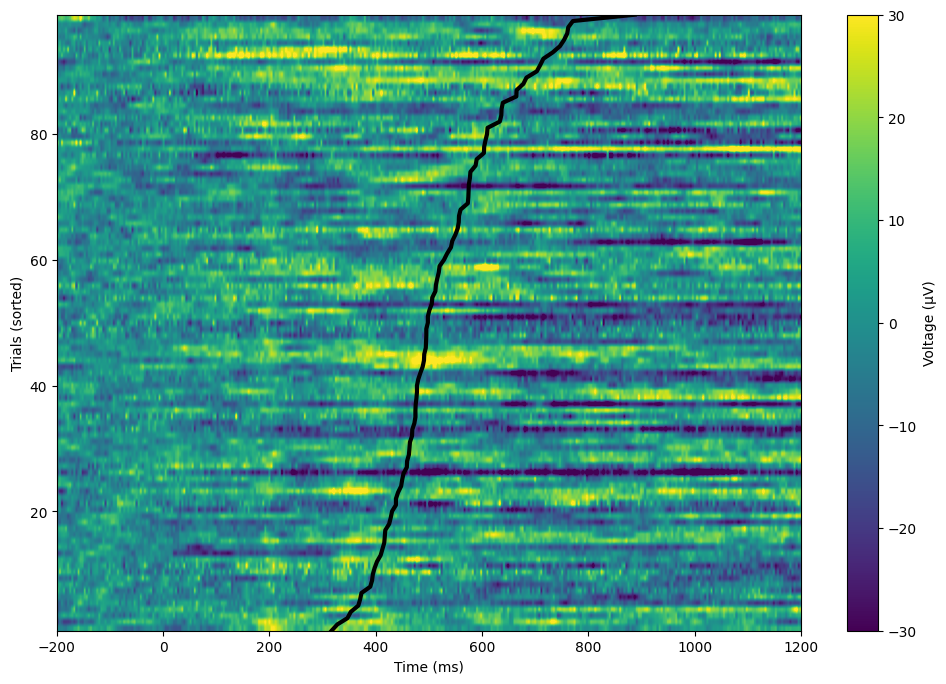

In [ ]:
useRTs = True  # Change to False to sort by EEG data

# Get RTs from each trial
rts = np.array([epoch['eventlatency'][0][np.where(np.array(epoch['eventlatency'][0]) == 0)[0][0] + 1][0][0] for epoch in EEG['epoch'][0]])

# Find the sorting indices for RTs
if useRTs:
    rts_idx = np.argsort(rts)
else:
    rts_idx = np.argsort(EEG['data'][46, 333, :])

# Plot sorted data
plt.figure(figsize=(12, 8))
plt.imshow(EEG['data'][46, :, rts_idx], aspect='auto', extent=[min(EEG['times'][0]), max(EEG['times'][0]), 1, EEG['trials'][0][0]], vmin=-30, vmax=30, origin="lower", cmap='viridis')
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel('Trials (sorted)')
plt.colorbar(label='Voltage (μV)')

# Also plot the RTs on each trial
if useRTs:
    plt.plot(rts[rts_idx], np.arange(1, EEG['trials'][0][0] + 1), 'k', linewidth=3)
plt.show()